# Final Project: Customer Segmentation and Behavior Prediction
In this project, students will use a synthetic dataset representing customer data from a retail company. The dataset contains demographic information, purchasing patterns, and interaction metrics. The objectives are to segment the customer base, predict future purchase behavior, and identify potential churn using a variety of data science techniques.

## 1. Preparation

### Package downloads

In [1]:
#Import neccessary packages to support project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Jupyter Notebook Setup

In [2]:
#Set the maximum number of rows
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns',100)

### Data File Understanding

In [3]:
#Read the csv file
data_original = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Advanced Data Science/Final Project/Data File/customer_data.csv')
data_original

,Customer_ID,Age,Gender,Annual_Income,Total_Purchases,Average_Purchase_Value,Product_Category_Most_Purchased,Website_Visits_Last_Month,Marketing_Emails_Opened,Hours_Spent_on_Support_Calls,Churn,Future_Purchase
0,1,39,Male,44520,4,44.291883,Clothing,12,3,0.360258,0,1
1,2,33,Female,52770,3,121.963922,Electronics,12,8,0.141300,1,1
2,3,41,Male,29793,5,100.599885,Electronics,9,4,0.482833,0,1
3,4,50,Female,35425,1,94.843412,Home,6,4,0.227715,0,1
4,5,32,Male,68006,6,119.680829,Books,6,3,1.032819,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,32,Female,65528,5,91.889202,Books,15,7,0.195086,0,1
996,997,52,Male,22307,5,128.412366,Books,10,4,1.146425,0,1
997,998,41,Female,36057,7,97.511384,Home,6,6,0.756008,0,0
998,999,29,Male,27552,7,128.785870,Home,13,6,0.086859,0,1


In [4]:
#Make a copy of the original data to be manipulated
data = data_original.copy()

There are 1000 instances with 12 different parameters

- Customer_ID: Unique identifier for the customer
- Age: Customer's age
- Gender: Customer's gender
- Annual_Income: Annual income of the customer
- Total_Purchases: Total number of purchases made by the customer
- Average_Purchase_Value: Average value of purchases
- Product_Category_Most_Purchased: Category of the most purchased products
- Website_Visits_Last_Month: Number of times the customer visited the website in the last month
- Marketing_Emails_Opened: Number of marketing emails opened by the customer
- Hours_Spent_on_Support_Calls: Total hours spent by the customer on support calls
- Churn: 1 if they are leaving as a customer, and 0 if they stay
- Future Purchases: They bought products in the future

### Function Creation (can be ignored)

In [5]:
#Create a function that goes through columns of dataframe and returns information about them
def print_column_types(dataframe):

    for column in dataframe.columns:
        dtype = dataframe[column].dtype
        nature = "numerical" if dataframe[column].dtype.kind in 'iufc' else "categorical"
        print(f"Column '{column}' has data type: {dtype} - {nature}")


In [6]:
from sklearn.preprocessing import MinMaxScaler

def min_max_scale_columns(dataframe, columns):
    
    #Create a MinMaxScaler object
    scaler = MinMaxScaler()

    #Scale the specified columns
    dataframe_scaled = dataframe.copy()
    dataframe_scaled[columns] = scaler.fit_transform(dataframe[columns])

    return dataframe_scaled


In [7]:
def calculate_mean_by_age_group(dataframe, age_column, bins, labels, columns_to_mean):
    # Create a new column for age group
    dataframe['Age_Group'] = pd.cut(dataframe[age_column], bins=bins, labels=labels, right=False)
    
    # Group by age group and calculate mean for each column
    mean_by_age_group = dataframe.groupby('Age_Group')[columns_to_mean].mean()
    
    return mean_by_age_group

In [8]:
def numeric_dataframe(data, column, bins, labels):

    # Create a new column with binned values
    data[column + '_Group'] = pd.cut(data[column], bins=bins, labels=labels, right=False)
    
    # Map labels to integers
    label_map = {label: i + 1 for i, label in enumerate(labels)}
    data[column + '_Group'] = data[column + '_Group'].map(label_map)
    
    # Drop the original numerical column
    data.drop(columns=column, inplace=True)

In [9]:
def categorical_dataframe(data_categorical, column, bins, labels):

    # Create a new column with binned values
    data_categorical[column + '_Group'] = pd.cut(data_categorical[column], bins=bins, labels=labels, right=False)
    
    # Map labels to integers
    label_map = {label: i + 1 for i, label in enumerate(labels)}
    
    # Drop the original numerical column
    data_categorical.drop(columns=column, inplace=True)

In [10]:
def plot_histogram_with_kde(data, column, bins, xlabel,ylabel,title, density=True, alpha=0.5, hist_color='blue', kde_color='red', kde_linestyle='--'):
    # Plot the histogram
    plt.hist(data[column], bins=bins, density=density, alpha=alpha, color=hist_color, label='Histogram')

    # Compute the kernel density estimation (KDE) of the data
    kde = sns.kdeplot(data[column], color=kde_color, linestyle=kde_linestyle, label='KDE')

    # Add labels and legend
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

    # Show the plot
    plt.show()

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, gamma

def fit_distributions_and_plot(data, hist_bins, xlabel,ylabel, title, plot=True):
    # Create histogram of the data, adjusting 'density' to True for probability density
    counts, bins, _ = plt.hist(data, bins=hist_bins, density=True, color='lightblue', alpha=0.7, label='Histogram of data')

    # Define the distributions to test
    distributions = [norm, expon, gamma]

    # Fit the distributions to the data and plot
    x = np.linspace(min(data), max(data), 1000)
    sse = []  # List to store sum of squared errors for each distribution

    for distribution in distributions:
        # Fit distribution to data
        params = distribution.fit(data)

        # Separate parts of parameters: args (shape), loc (location), scale (scale)
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate the PDF values for each x and for the bin centers
        pdf_values = distribution.pdf(x, *arg, loc=loc, scale=scale)
        estimated_pdf = distribution.pdf(bins[:-1] + np.diff(bins) / 2, *arg, loc=loc, scale=scale)

        # Adjust the estimated PDF by the bin widths to compute the SSE correctly
        bin_widths = np.diff(bins)
        adjusted_pdf = estimated_pdf * bin_widths

        # Calculate the SSE between the observed counts and the estimated PDF values
        sse.append(np.sum((counts - adjusted_pdf) ** 2))

        if plot:
            # Plot the fitted distribution
            plt.plot(x, pdf_values, label=f'{distribution.name} fit')

    if plot:
        # Add plot formatting
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()

        # Display the plot
        plt.show()

    # Print the SSE values for each fitted distribution
    for dist, error in zip(distributions, sse):
        print(f'{dist.name} SSE: {error}')

    return sse

## 1. Data Preprocessing
Handle missing values, encode categorical variables, and scale numerical data.

In [12]:
#Use the function from above to make sure that all of the columns have the correct dtype
print_column_types(data_original)

Column 'Customer_ID' has data type: int64 - numerical
Column 'Age' has data type: int64 - numerical
Column 'Gender' has data type: object - categorical
Column 'Annual_Income' has data type: int64 - numerical
Column 'Total_Purchases' has data type: int64 - numerical
Column 'Average_Purchase_Value' has data type: float64 - numerical
Column 'Product_Category_Most_Purchased' has data type: object - categorical
Column 'Website_Visits_Last_Month' has data type: int64 - numerical
Column 'Marketing_Emails_Opened' has data type: int64 - numerical
Column 'Hours_Spent_on_Support_Calls' has data type: float64 - numerical
Column 'Churn' has data type: int64 - numerical
Column 'Future_Purchase' has data type: int64 - numerical


#### dtype of columns
Numerical
- 'Customer_ID'
- 'Age'
- 'Annual_Income'
- 'Total_Purchases'
- 'Average_Purchase_Value'
- 'Website_Visits_Last_Month'
- 'Marketing_Emails_Opened'
- 'Hours_Spent_on_Support_Calls'

Categorical
- 'Gender'
- 'Product_Category_Most_Purchased'
- 'Future_Purchase'
- 'Churn'

In [13]:
#Create a list of numerical columns
numerical_continuous_columns = ['Age','Annual_Income','Total_Purchases','Average_Purchase_Value','Website_Visits_Last_Month','Marketing_Emails_Opened','Hours_Spent_on_Support_Calls']

#Create a list of categorical columns
categorical_columns = ['Gender','Product_Category_Most_Purchased','Future_Purchase','Churn']

### Creating Dummy Variables

In [14]:
#Output the number of responses available for categorical variables
print(f"Product_Category_Most_Purchased outcomes: {data_original['Product_Category_Most_Purchased'].unique()}") 
print(f"Gender outcomes: {data_original['Gender'].unique()}")

#Churn and Future Purchase are already in a dummy format

Product_Category_Most_Purchased outcomes: ['Clothing' 'Electronics' 'Home' 'Books' 'Health']
Gender outcomes: ['Male' 'Female']


#### 1. Product Category Most Purchased Dummy Variables

In [15]:
#Create dummy variables for first categorical columns using 
Product_Category_Most_Purchased_dummies = pd.get_dummies(data_original['Product_Category_Most_Purchased'])
Product_Category_Most_Purchased_dummies

,Books,Clothing,Electronics,Health,Home
0,0,1,0,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,0,0,1
4,1,0,0,0,0
...,...,...,...,...,...
995,1,0,0,0,0
996,1,0,0,0,0
997,0,0,0,0,1
998,0,0,0,0,1


#### 2. Gender Dummy Variables

In [16]:
#Create dummy variables for second categorical columns 
Gender_dummies = pd.get_dummies(data_original['Gender'])
Gender_dummies

,Female,Male
0,0,1
1,1,0
2,0,1
3,1,0
4,0,1
...,...,...
995,1,0
996,0,1
997,1,0
998,0,1


#### Concatenate the dummy variables into new df

In [17]:
#Create copy of original dataframe
data_dummy = data.copy()
data_dummy = pd.concat([data_dummy,Product_Category_Most_Purchased_dummies,Gender_dummies],axis=1)

#Drop the original values as they will not be used for analysis
data_dummy.drop(columns={'Product_Category_Most_Purchased','Gender'},inplace=True)
data_dummy

,Customer_ID,Age,Annual_Income,Total_Purchases,Average_Purchase_Value,Website_Visits_Last_Month,Marketing_Emails_Opened,Hours_Spent_on_Support_Calls,Churn,Future_Purchase,Books,Clothing,Electronics,Health,Home,Female,Male
0,1,39,44520,4,44.291883,12,3,0.360258,0,1,0,1,0,0,0,0,1
1,2,33,52770,3,121.963922,12,8,0.141300,1,1,0,0,1,0,0,1,0
2,3,41,29793,5,100.599885,9,4,0.482833,0,1,0,0,1,0,0,0,1
3,4,50,35425,1,94.843412,6,4,0.227715,0,1,0,0,0,0,1,1,0
4,5,32,68006,6,119.680829,6,3,1.032819,0,1,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,32,65528,5,91.889202,15,7,0.195086,0,1,1,0,0,0,0,1,0
996,997,52,22307,5,128.412366,10,4,1.146425,0,1,1,0,0,0,0,0,1
997,998,41,36057,7,97.511384,6,6,0.756008,0,0,0,0,0,0,1,1,0
998,999,29,27552,7,128.785870,13,6,0.086859,0,1,0,0,0,0,1,0,1


In [18]:
#Create a list of columns that are dummy variables
dummy_variables_columns = ['Books','Clothing','Electronics','Health','Home','Female','Male']

### Transform continous variables into numerical variables using integer encoding and labeling categories
Turn the following columns into bin values to be added to a new dataframe
- Age
- Annual Income
- Total Purchases
- Average Purchase Value
- Websites Visits Last Month
- Marketing Emails Opened
- Hours Spent on Support Calls

In [19]:
#Create a copy of data_dummy as data_dummy_integer_encoding
data_dummy_integer_encoding = data_dummy.copy()

#Create a copy of data_dummy as data_label_categorical
data_label_categorical = data.copy()

#### Age column to categorical variable

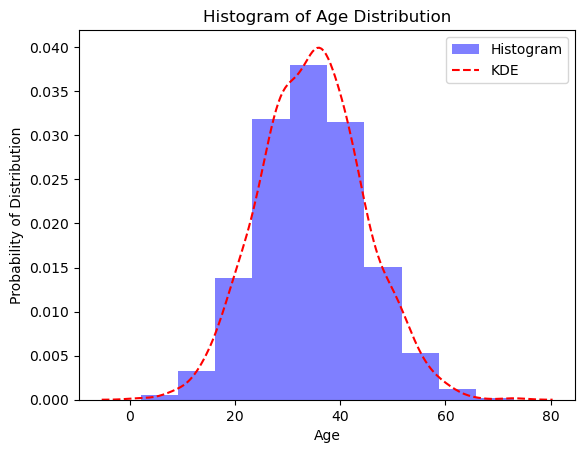

In [20]:
#Create a histogram of discrete numerical age column
plot_histogram_with_kde(data,'Age',10,'Age','Probability of Distribution','Histogram of Age Distribution')

The data has a normal distribution. This means that it follows a bell curve and the mass of the valuesa are around the mean.

In [21]:
#Find the minimum and maximum values
print('Minimum Age:',data_original['Age'].min())
print('Maximum Age:',data_original['Age'].max())

Minimum Age: 2
Maximum Age: 73


The age difference is 71. So make 7 bins as follows:
- 2-10 (1)
- 11-20 (2)
- 21-30 (3)
- 31-40 (4)
- 41-50 (5)
- 51-60 (6)
- 61-73 (7)

In [22]:
# Assuming data_dummy_integer_encoding is your DataFrame and data_original is your original DataFrame
bins_age = [2, 10, 20, 30, 40, 50, 60, 73]
labels_age = ['2-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-73']

#Create a dataframe that uses categorical variables labelled as 1-7
numeric_dataframe(data_dummy_integer_encoding,'Age',bins_age,labels_age)

#Create a dataframe that uses categorical variables labeled as their bin label
categorical_dataframe(data_label_categorical,'Age',bins_age,labels_age)

#### Annual_Income to categorical variable

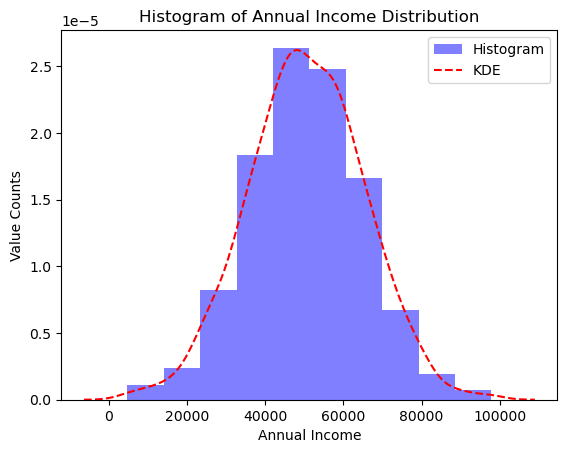

In [23]:
#Create a histogram of discrete numerical age column
plot_histogram_with_kde(data,'Annual_Income',10,'Annual Income','Value Counts','Histogram of Annual Income Distribution')

The data has a normal distribution. This means that it follows a bell curve and the mass of the valuesa are around the mean.

In [24]:
#Find the minimum and maximum values
print('Minimum Income:',data_dummy_integer_encoding['Annual_Income'].min())
print('Maximum Income:',data_dummy_integer_encoding['Annual_Income'].max())

Minimum Income: 4707
Maximum Income: 97896


Make the following bins
- 4500-20000 (1)
- 20000-40000 (2)
- 40000 - 60000 (3)
- 60000 - 80000 (4)
- 80000 - 100000 (5)

In [25]:
#Create bins and labels for annual income based off of histogram as well as min/max
bins_annual_income = [4500,20000,40000,60000,80000,100000]
labels_annual_income = ['4500-20000', '20000-40000', '40000-60000', '60000-80000', '80000- 100000']

#Create a dataframe that uses categorical variables labelled as 1-5
numeric_dataframe(data_dummy_integer_encoding,'Annual_Income',bins_annual_income,labels_annual_income)

#Create a dataframe that uses categorical variables labeled as their bin label
categorical_dataframe(data_label_categorical,'Annual_Income',bins_annual_income,labels_annual_income)

#### Total_Purchases into categorical variable

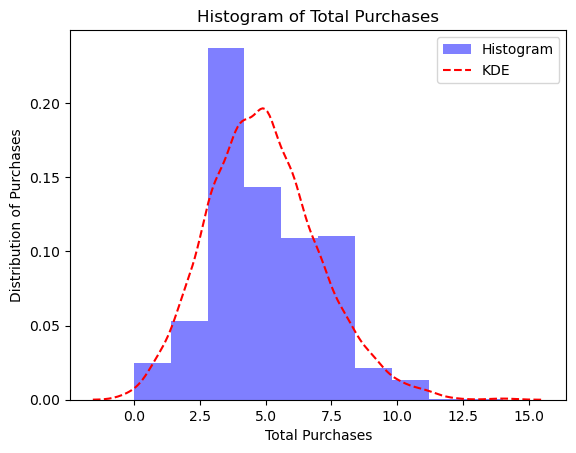

In [26]:
#Create the histogram of total purchases with the kde
plot_histogram_with_kde(data,'Total_Purchases',10,'Total Purchases','Distribution of Purchases','Histogram of Total Purchases')

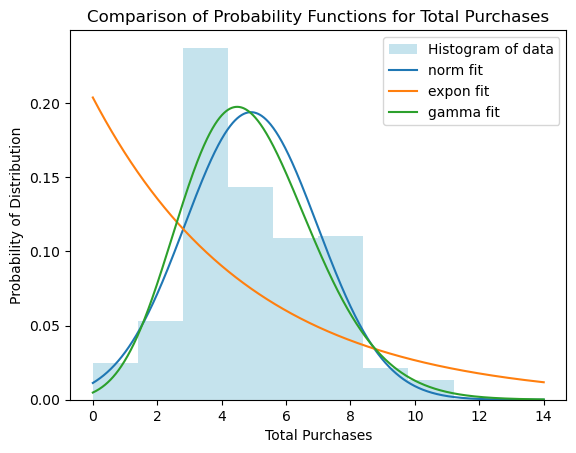

norm SSE: 0.031398357510996934
expon SSE: 0.083382494106411
gamma SSE: 0.027834124902261875


[0.031398357510996934, 0.083382494106411, 0.027834124902261875]

In [27]:
#Fit the distribution which best fits the model
fit_distributions_and_plot(data['Total_Purchases'],10,'Total Purchases','Probability of Distribution','Comparison of Probability Functions for Total Purchases')

The distribution best fits the gamma distribution.

In [28]:
#Find the minimum and maximum values
print('Minimum Purchases:',data_dummy_integer_encoding['Total_Purchases'].min())
print('Maximum Purchases:',data_dummy_integer_encoding['Total_Purchases'].max())

Minimum Purchases: 0
Maximum Purchases: 14


Create the following bins for total purchases
- 0-2
- 3-5
- 6-8
- 9-11
- 12-14


In [29]:
#Create bins and labels for total purchases column
bins_total_purchases = [0,3,6,9,12,14]
labels_total_purchases = ['0-2','3-5','6-8','9-11','12-14']

#Modify the numeric dataframe
numeric_dataframe(data_dummy_integer_encoding,'Total_Purchases',bins_total_purchases,labels_total_purchases)

#Modify the categorical dataframe
categorical_dataframe(data_label_categorical,'Total_Purchases',bins_total_purchases,labels_total_purchases)

#### Average_Purchase_Value into categorical variable

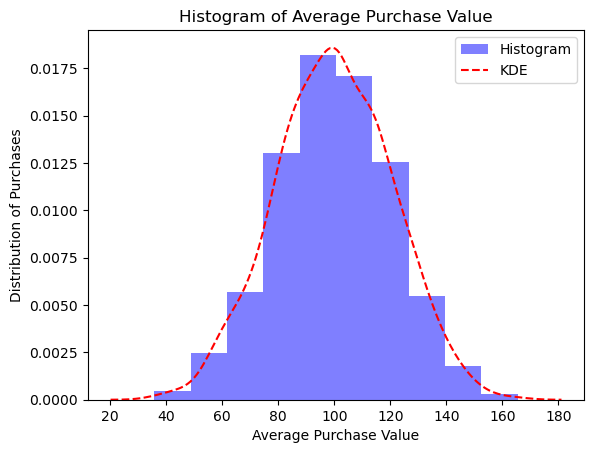

In [30]:
#Create the histogram of total purchases with the kde
plot_histogram_with_kde(data,'Average_Purchase_Value',10,'Average Purchase Value','Distribution of Purchases','Histogram of Average Purchase Value')

The data has a bell curve shape which means that has a normal distribution where values are centered around the mean

In [31]:
#Find the minimum and maximum values
print('Minimum Average Purchase Value:',data_dummy_integer_encoding['Average_Purchase_Value'].min())
print('Maximum Average Purchase Value:',data_dummy_integer_encoding['Average_Purchase_Value'].max())

Minimum Average Purchase Value: 35.678856014857274
Maximum Average Purchase Value: 165.52798690226


Create the following bins for average purchase value
- 30-65
- 65-100
- 100-135
- 135-170

In [32]:
#Create bins and labels for average purchase column
bins_average_purchase_value = [30,65,100,135,170]
labels_average_purchase_value = ['30-65','65-100','100-135','135-170']

#Modify the numeric dataframe
numeric_dataframe(data_dummy_integer_encoding,'Average_Purchase_Value',bins_average_purchase_value,labels_average_purchase_value)

#Modify the categorical dataframe
categorical_dataframe(data_label_categorical,'Average_Purchase_Value',bins_average_purchase_value,labels_average_purchase_value)

#### Website_Visits_Last_Month to categorical variable

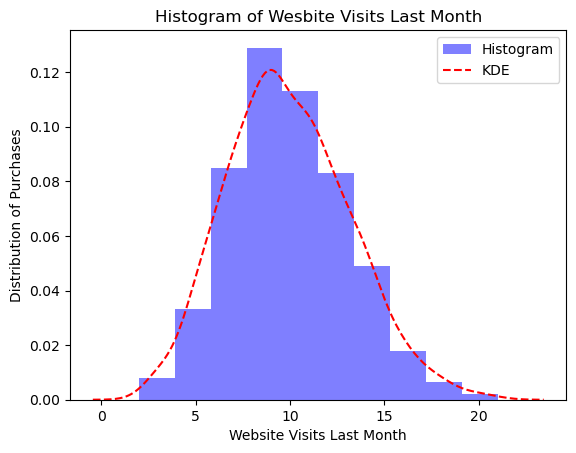

In [33]:
#Create the histogram of website visits last month with the kde
plot_histogram_with_kde(data,'Website_Visits_Last_Month',10,'Website Visits Last Month','Distribution of Purchases','Histogram of Wesbite Visits Last Month')

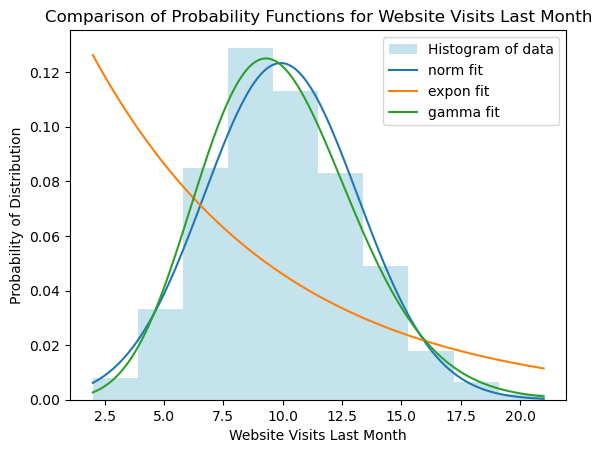

norm SSE: 0.036609087391849
expon SSE: 0.0657985935937492
gamma SSE: 0.036943467082101604


[0.036609087391849, 0.0657985935937492, 0.036943467082101604]

In [34]:
#Fit the distribution which best fits the model
fit_distributions_and_plot(data['Website_Visits_Last_Month'],10,'Website Visits Last Month','Probability of Distribution','Comparison of Probability Functions for Website Visits Last Month')

This has a SSE which is very close to the normal distribution and gamma distribution. It seems that it is normally distribution with a mean that has been shifted to the left.

In [35]:
#Find the minimum and maximum values
print('Minimum Website Visits Last Month:',data_dummy_integer_encoding['Website_Visits_Last_Month'].min())
print('Maximum Website Visits Last Month:',data_dummy_integer_encoding['Website_Visits_Last_Month'].max())

Minimum Website Visits Last Month: 2
Maximum Website Visits Last Month: 21


Create the following bins for website visits last month
- 2-5
- 6-9 
- 10-13
- 14-17
- 18-21

In [36]:
#Create bins and labels 
bins_website_visits = [2,6,10,13,17,21]
labels_website_visits = ['2-5','6-9','10-13','14-17','18-21']

#Modify the numeric dataframe
numeric_dataframe(data_dummy_integer_encoding,'Website_Visits_Last_Month',bins_website_visits,labels_website_visits)

#Modify the categorical dataframe
categorical_dataframe(data_label_categorical,'Website_Visits_Last_Month',bins_website_visits,labels_website_visits)

#### Marketing Emails Opened to Categorical Variable

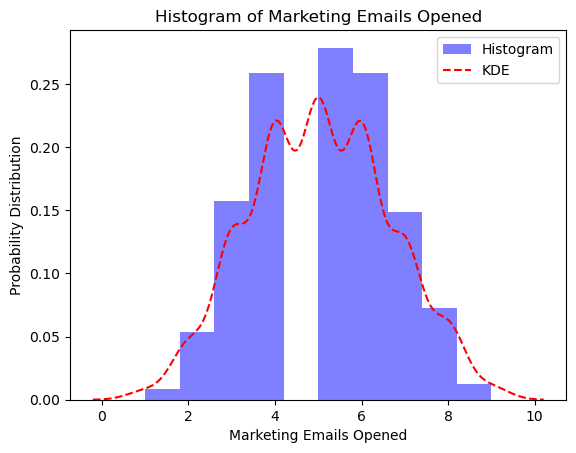

In [37]:
#Create the histogram of website visits last month with the kde
plot_histogram_with_kde(data,'Marketing_Emails_Opened',10,'Marketing Emails Opened','Probability Distribution','Histogram of Marketing Emails Opened')

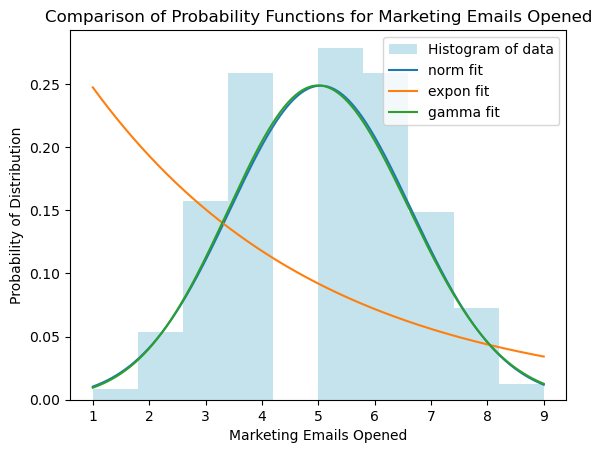

norm SSE: 0.07601251888871306
expon SSE: 0.17026269941165914
gamma SSE: 0.07674033826937379


[0.07601251888871306, 0.17026269941165914, 0.07674033826937379]

In [38]:
#Fit the distribution which best fits the model
fit_distributions_and_plot(data['Marketing_Emails_Opened'],10,'Marketing Emails Opened','Probability of Distribution','Comparison of Probability Functions for Marketing Emails Opened')

The data has a bell curve which means it is normally distributed and has a central value about the mean

In [39]:
#Find the minimum and maximum values
print('Minimum Marketing Emails Opened:',data_dummy_integer_encoding['Marketing_Emails_Opened'].min())
print('Maximum Marketing Emails Opened:',data_dummy_integer_encoding['Marketing_Emails_Opened'].max())

Minimum Marketing Emails Opened: 1
Maximum Marketing Emails Opened: 9


Create bins of the following steps for marketing emails opened
- 1-2
- 3-4
- 5-6
- 7-9

In [40]:
#Create bins and labels for marketing emails opened
bins_marketing_emails_opened = [1,3,5,7,9]
labels_marketing_emails_opened = ['1-2', '3-4', '5-6','7-9']

#Modify the numeric dataframe
numeric_dataframe(data_dummy_integer_encoding,'Marketing_Emails_Opened',bins_marketing_emails_opened,labels_marketing_emails_opened)

#Modify the categorical dataframe
categorical_dataframe(data_label_categorical,'Marketing_Emails_Opened',bins_marketing_emails_opened,labels_marketing_emails_opened)

#### Hours Spent on Support Calls to Categorical

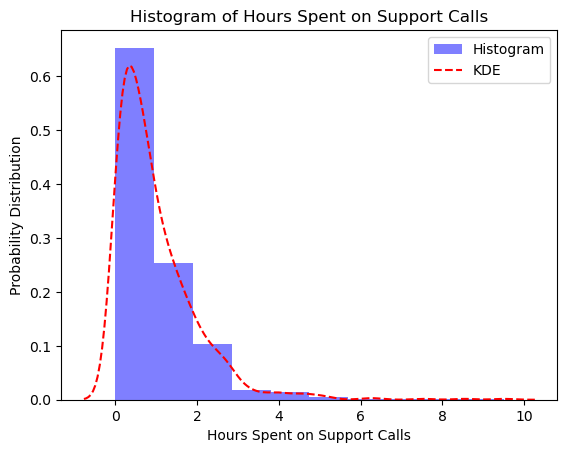

In [41]:
#Create a histogram of the hours spent on support calls distribution
plot_histogram_with_kde(data, 'Hours_Spent_on_Support_Calls',10,'Hours Spent on Support Calls','Probability Distribution','Histogram of Hours Spent on Support Calls')

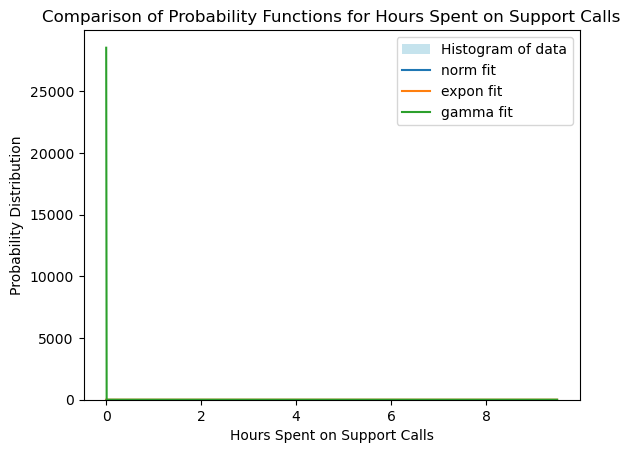

norm SSE: 0.11452473099307307
expon SSE: 0.004614791880057503
gamma SSE: 0.020940085362297772


[0.11452473099307307, 0.004614791880057503, 0.020940085362297772]

In [42]:
#Fit the distribution to the graph
fit_distributions_and_plot(data['Hours_Spent_on_Support_Calls'],10,'Hours Spent on Support Calls','Probability Distribution','Comparison of Probability Functions for Hours Spent on Support Calls')

This data is exponentially decyaing where the number of hours spent on support calls is centred close towards 0 where as there are some values which continue out to 7.

In [43]:
#Find the minimum and maximum values
print('Minimum Hours Spent on Support Call:',data_dummy_integer_encoding['Hours_Spent_on_Support_Calls'].min())
print('Maximum Hours Spent on Support Call:',data_dummy_integer_encoding['Hours_Spent_on_Support_Calls'].max())

Minimum Hours Spent on Support Call: 0.0005543382022885
Maximum Hours Spent on Support Call: 9.495716214841172


Create the following bins for hours spent on support calls
- 0-2
- 2-4
- 4-6
- 6-8
- 8-10

In [44]:
#Create bins and labels for hours spent on support calls
bins_hours_spent_on_support_call = [0,2,4,6,8,10]
labels_hours_spent_on_support_call = ['0-2', '2-4', '4-6', '6-8', '8-10']

#Modify the numeric dataframe
numeric_dataframe(data_dummy_integer_encoding,'Hours_Spent_on_Support_Calls',bins_hours_spent_on_support_call,labels_hours_spent_on_support_call)

#Modify the categorical dataframe
categorical_dataframe(data_label_categorical,'Hours_Spent_on_Support_Calls',bins_hours_spent_on_support_call,labels_hours_spent_on_support_call)

#### Review of New Dataframes
- data_dummy_integer_encoding
- data_label_categorical

In [45]:
#Output the new dataframe which has has numerical values for each difference of segmentation
data_dummy_integer_encoding

,Customer_ID,Churn,Future_Purchase,Books,Clothing,Electronics,Health,Home,Female,Male,Age_Group,Annual_Income_Group,Total_Purchases_Group,Average_Purchase_Value_Group,Website_Visits_Last_Month_Group,Marketing_Emails_Opened_Group,Hours_Spent_on_Support_Calls_Group
0,1,0,1,0,1,0,0,0,0,1,4,3,2,1,3,2,1
1,2,1,1,0,0,1,0,0,1,0,4,3,2,3,3,4,1
2,3,0,1,0,0,1,0,0,0,1,5,2,2,3,2,2,1
3,4,0,1,0,0,0,0,1,1,0,6,2,1,2,2,2,1
4,5,0,1,1,0,0,0,0,0,1,4,4,3,3,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,0,1,1,0,0,0,0,1,0,4,4,2,2,4,4,1
996,997,0,1,1,0,0,0,0,0,1,6,2,2,3,3,2,1
997,998,0,0,0,0,0,0,1,1,0,5,2,3,2,2,3,1
998,999,0,1,0,0,0,0,1,0,1,3,2,3,3,4,3,1


In [46]:
#Output the new dataframe which has categorical values for each difference of segmentation
data_label_categorical

,Customer_ID,Gender,Product_Category_Most_Purchased,Churn,Future_Purchase,Age_Group,Annual_Income_Group,Total_Purchases_Group,Average_Purchase_Value_Group,Website_Visits_Last_Month_Group,Marketing_Emails_Opened_Group,Hours_Spent_on_Support_Calls_Group
0,1,Male,Clothing,0,1,31-40,40000-60000,3-5,30-65,10-13,3-4,0-2
1,2,Female,Electronics,1,1,31-40,40000-60000,3-5,100-135,10-13,7-9,0-2
2,3,Male,Electronics,0,1,41-50,20000-40000,3-5,100-135,6-9,3-4,0-2
3,4,Female,Home,0,1,51-60,20000-40000,0-2,65-100,6-9,3-4,0-2
4,5,Male,Books,0,1,31-40,60000-80000,6-8,100-135,6-9,3-4,0-2
...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,Female,Books,0,1,31-40,60000-80000,3-5,65-100,14-17,7-9,0-2
996,997,Male,Books,0,1,51-60,20000-40000,3-5,100-135,10-13,3-4,0-2
997,998,Female,Home,0,0,41-50,20000-40000,6-8,65-100,6-9,5-6,0-2
998,999,Male,Home,0,1,21-30,20000-40000,6-8,100-135,14-17,5-6,0-2


In [47]:
# Assuming data_label_categorical is your DataFrame
data_label_categorical['Churn'] = data_label_categorical['Churn'].map({1: 'Yes', 0: 'No'})
data_label_categorical['Future_Purchase'] = data_label_categorical['Future_Purchase'].map({1: 'Yes', 0: 'No'})
data_label_categorical

,Customer_ID,Gender,Product_Category_Most_Purchased,Churn,Future_Purchase,Age_Group,Annual_Income_Group,Total_Purchases_Group,Average_Purchase_Value_Group,Website_Visits_Last_Month_Group,Marketing_Emails_Opened_Group,Hours_Spent_on_Support_Calls_Group
0,1,Male,Clothing,No,Yes,31-40,40000-60000,3-5,30-65,10-13,3-4,0-2
1,2,Female,Electronics,Yes,Yes,31-40,40000-60000,3-5,100-135,10-13,7-9,0-2
2,3,Male,Electronics,No,Yes,41-50,20000-40000,3-5,100-135,6-9,3-4,0-2
3,4,Female,Home,No,Yes,51-60,20000-40000,0-2,65-100,6-9,3-4,0-2
4,5,Male,Books,No,Yes,31-40,60000-80000,6-8,100-135,6-9,3-4,0-2
...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,Female,Books,No,Yes,31-40,60000-80000,3-5,65-100,14-17,7-9,0-2
996,997,Male,Books,No,Yes,51-60,20000-40000,3-5,100-135,10-13,3-4,0-2
997,998,Female,Home,No,No,41-50,20000-40000,6-8,65-100,6-9,5-6,0-2
998,999,Male,Home,No,Yes,21-30,20000-40000,6-8,100-135,14-17,5-6,0-2


In [48]:
#Save the numeric inter encoded dataframe to file
data_dummy_integer_encoding.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Advanced Data Science/Final Project/Data File/integer_encoded_customer_data.csv')

#Save the categorical split dataframe to file
data_label_categorical.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Advanced Data Science/Final Project/Data File/categorical_customer_data.csv')

### Value Counts of Different Columns

In [49]:
data_dummy_integer_encoding
import pandas as pd

# Assuming 'data' is your DataFrame containing the customer data
# Extracting the relevant columns
columns_to_count = ['Churn', 'Books', 'Clothing', 'Electronics', 'Health', 'Home', 'Female', 'Male',
                    'Age_Group', 'Annual_Income_Group', 'Total_Purchases_Group', 
                    'Average_Purchase_Value_Group', 'Website_Visits_Last_Month_Group', 
                    'Marketing_Emails_Opened_Group', 'Hours_Spent_on_Support_Calls_Group']

# Create a new DataFrame with just the selected columns
selected_data = data_dummy_integer_encoding[columns_to_count]

# Calculating value counts for each column
value_counts = selected_data.apply(pd.Series.value_counts)

value_counts

,Churn,Books,Clothing,Electronics,Health,Home,Female,Male,Age_Group,Annual_Income_Group,Total_Purchases_Group,Average_Purchase_Value_Group,Website_Visits_Last_Month_Group,Marketing_Emails_Opened_Group,Hours_Spent_on_Support_Calls_Group
0,844.0,788.0,782.0,801.0,822.0,807.0,489.0,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,156.0,212.0,218.0,199.0,178.0,193.0,511.0,489.0,4.0,19.0,109.0,51.0,78.0,50.0,875.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.0,211.0,533.0,454.0,406.0,333.0,107.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256.0,510.0,307.0,454.0,303.0,430.0,13.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,381.0,238.0,49.0,41.0,185.0,177.0,3.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,231.0,22.0,1.0,NaN,27.0,NaN,2.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN


#### Percentage values of value counts

In [50]:
# Calculate the sum of counts in each column
total_counts = value_counts.sum(axis=0)

# Create a list to store the percentages
percentages_list = []

# Iterate through each column
for column in columns_to_count:
    # Calculate the sum of counts in the current column
    total_count = total_counts[column]
    
    # Calculate the percentage of each count value in the current column
    percentages = [count / total_count for count in value_counts[column]]
    
    # Append the percentages to the list
    percentages_list.append(percentages)

# Create a DataFrame from the list of percentages
percentages_df = pd.DataFrame(percentages_list, columns=value_counts.index, index=columns_to_count)

# Transpose the DataFrame to have counts as columns and columns as rows
percentages_df = percentages_df.T

percentages_df.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Advanced Data Science/Final Project/Data File/percentage_values_customer_data.csv')

percentages_df

,Churn,Books,Clothing,Electronics,Health,Home,Female,Male,Age_Group,Annual_Income_Group,Total_Purchases_Group,Average_Purchase_Value_Group,Website_Visits_Last_Month_Group,Marketing_Emails_Opened_Group,Hours_Spent_on_Support_Calls_Group
0,0.844,0.788,0.782,0.801,0.822,0.807,0.489,0.511,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.156,0.212,0.218,0.199,0.178,0.193,0.511,0.489,0.004004,0.019,0.109109,0.051,0.078078,0.050505,0.875
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.053053,0.211,0.533534,0.454,0.406406,0.336364,0.107
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256256,0.510,0.307307,0.454,0.303303,0.434343,0.013
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.381381,0.238,0.049049,0.041,0.185185,0.178788,0.003
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.231231,0.022,0.001001,NaN,0.027027,NaN,0.002
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.068068,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006006,NaN,NaN,NaN,NaN,NaN,NaN


### Create a normalised dataframe
There are a few ways to do this:

- Min-Maxing 
- Z-score

I am going to be using the min-maxing to create normalised data

In [51]:
#Normalise data using function defined
data_dummy_normalised = min_max_scale_columns(data_dummy,data_dummy.columns[1:7])
data_dummy_normalised.set_index('Customer_ID',inplace=True)
#Export the data so that it can be used in orange
data_dummy_normalised.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Advanced Data Science/Final Project/Data File/normalised_customer_data.csv')
data_dummy_normalised

,Age,Annual_Income,Total_Purchases,Average_Purchase_Value,Website_Visits_Last_Month,Marketing_Emails_Opened,Hours_Spent_on_Support_Calls,Churn,Future_Purchase,Books,Clothing,Electronics,Health,Home,Female,Male
Customer_ID,,,,,,,,,,,,,,,,
1,0.521127,0.427229,0.285714,0.066331,0.526316,0.250,0.360258,0,1,0,1,0,0,0,0,1
2,0.436620,0.515758,0.214286,0.664502,0.526316,0.875,0.141300,1,1,0,0,1,0,0,1,0
3,0.549296,0.269195,0.357143,0.499973,0.368421,0.375,0.482833,0,1,0,0,1,0,0,0,1
4,0.676056,0.329631,0.071429,0.455641,0.210526,0.375,0.227715,0,1,0,0,0,0,1,1,0
5,0.422535,0.679254,0.428571,0.646920,0.210526,0.250,1.032819,0,1,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.422535,0.652663,0.357143,0.432890,0.684211,0.750,0.195086,0,1,1,0,0,0,0,1,0
997,0.704225,0.188863,0.357143,0.714164,0.421053,0.375,1.146425,0,1,1,0,0,0,0,0,1
998,0.549296,0.336413,0.500000,0.476187,0.210526,0.625,0.756008,0,0,0,0,0,0,1,1,0


This normalised data is going to be more useful when doing analysis as it takes out the scale as a factor that needs to be included. I created a new dataframe so that theo riginal can also be kept if needed again in the future.

### Review of different dataframes
- data : original data that can be manipulated
- data_original : original data that will not be touched
- data_dummy : original data that has dummy variables in place of the categories
- data_dummy_integer_encoding : dummy variables and categorical rankings 
- data_label_categories : takes the labels
- data_normalised : dummy variables included with original data that has been normalised
- percentages_df : look at the different percentages of distribution of values for segmented values
- value_counts : look at the value of distribution for segmented values

## 2. Clustering Techniques
Looking at the dataframes above. 
- percentages_df is used to remove certain variables for clustering if they have the same distribution

### Feature Selection for Clustering
With the hisogram analysis and distribution spread, choose which features to remove.

In [52]:
#Display the dataframe of percentage values
# Calculate the correlation matrix
percentages_df

,Churn,Books,Clothing,Electronics,Health,Home,Female,Male,Age_Group,Annual_Income_Group,Total_Purchases_Group,Average_Purchase_Value_Group,Website_Visits_Last_Month_Group,Marketing_Emails_Opened_Group,Hours_Spent_on_Support_Calls_Group
0,0.844,0.788,0.782,0.801,0.822,0.807,0.489,0.511,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.156,0.212,0.218,0.199,0.178,0.193,0.511,0.489,0.004004,0.019,0.109109,0.051,0.078078,0.050505,0.875
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.053053,0.211,0.533534,0.454,0.406406,0.336364,0.107
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256256,0.510,0.307307,0.454,0.303303,0.434343,0.013
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.381381,0.238,0.049049,0.041,0.185185,0.178788,0.003
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.231231,0.022,0.001001,NaN,0.027027,NaN,0.002
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.068068,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006006,NaN,NaN,NaN,NaN,NaN,NaN


Remove the following variables when clustering churn,books,clothing,electronics,health,home,female,male

In [53]:
#For k-means clustering use normalised data
clustering_normalised_df = data_dummy_normalised.drop(columns=['Churn','Books','Clothing','Electronics','Health','Home','Female','Male'])
clustering_normalised_df.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Advanced Data Science/Final Project/Data File/normalised_clustering_1_customer.csv')

#For hierachial clustering use integer encoded data
clustering_integer_encoded_df = data_dummy_integer_encoding.drop(columns=['Churn','Books','Clothing','Electronics','Health','Home','Female','Male'])
clustering_integer_encoded_df.set_index('Customer_ID',inplace=True)
clustering_integer_encoded_df.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Advanced Data Science/Final Project/Data File/integer_encoded_clustering_1_customer.csv')


In [54]:
#There still wasnt as clear of a cluster
#let's see if any others can be removed
percentages_df

,Churn,Books,Clothing,Electronics,Health,Home,Female,Male,Age_Group,Annual_Income_Group,Total_Purchases_Group,Average_Purchase_Value_Group,Website_Visits_Last_Month_Group,Marketing_Emails_Opened_Group,Hours_Spent_on_Support_Calls_Group
0,0.844,0.788,0.782,0.801,0.822,0.807,0.489,0.511,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.156,0.212,0.218,0.199,0.178,0.193,0.511,0.489,0.004004,0.019,0.109109,0.051,0.078078,0.050505,0.875
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.053053,0.211,0.533534,0.454,0.406406,0.336364,0.107
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256256,0.510,0.307307,0.454,0.303303,0.434343,0.013
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.381381,0.238,0.049049,0.041,0.185185,0.178788,0.003
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.231231,0.022,0.001001,NaN,0.027027,NaN,0.002
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.068068,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006006,NaN,NaN,NaN,NaN,NaN,NaN


- age
- total purchases
- hours spent on support calls

In [55]:
#For k-means clustering use normalised data
clustering_normalised_df_2 = clustering_normalised_df[['Age','Total_Purchases','Hours_Spent_on_Support_Calls']]
clustering_normalised_df_2.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Advanced Data Science/Final Project/Data File/normalised_clustering_2_customer.csv')

#For hierachial clustering use integer encoded data
clustering_integer_encoded_df_2 = clustering_integer_encoded_df[['Age_Group','Total_Purchases_Group','Hours_Spent_on_Support_Calls_Group']]
clustering_integer_encoded_df_2.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Advanced Data Science/Final Project/Data File/integer_encoded_clustering_2_customer.csv')

#### K-Means Clustering

See code file and look under 'orange code for clustering.ows' to see how I came to my conclusion for the clustering patterns.

In [56]:
#Create a dataframe which includes the clustering
clustered_data = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Advanced Data Science/Final Project/Data File/clustered_data_columns_removed_integer_encoding.csv')
cluster = clustered_data['Cluster']
# Remove the first two values from the 'cluster' Series
cluster_trimmed = cluster.iloc[2:]

# Reset the index of the 'cluster_trimmed' Series
cluster_trimmed_reset = cluster_trimmed.reset_index(drop=True)

##### Add cluster data to dataframe

In [57]:
# Add the trimmed 'cluster' Series as a new column 'Cluster Value' to the 'data' DataFrame
data['K-Means Cluster Value'] = cluster_trimmed_reset

# Display the updated 'data' DataFrame
data

,Customer_ID,Age,Gender,Annual_Income,Total_Purchases,Average_Purchase_Value,Product_Category_Most_Purchased,Website_Visits_Last_Month,Marketing_Emails_Opened,Hours_Spent_on_Support_Calls,Churn,Future_Purchase,K-Means Cluster Value
0,1,39,Male,44520,4,44.291883,Clothing,12,3,0.360258,0,1,C1
1,2,33,Female,52770,3,121.963922,Electronics,12,8,0.141300,1,1,C1
2,3,41,Male,29793,5,100.599885,Electronics,9,4,0.482833,0,1,C1
3,4,50,Female,35425,1,94.843412,Home,6,4,0.227715,0,1,C1
4,5,32,Male,68006,6,119.680829,Books,6,3,1.032819,0,1,C1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,32,Female,65528,5,91.889202,Books,15,7,0.195086,0,1,C1
996,997,52,Male,22307,5,128.412366,Books,10,4,1.146425,0,1,C1
997,998,41,Female,36057,7,97.511384,Home,6,6,0.756008,0,0,C1
998,999,29,Male,27552,7,128.785870,Home,13,6,0.086859,0,1,C1


In [58]:
data_label_categorical['K-Means Cluster Value'] = cluster_trimmed

In [59]:
#C1, C2, C3 data
C1_data = data_label_categorical[data_label_categorical['K-Means Cluster Value'] == 'C1']
C2_data = data_label_categorical[data_label_categorical['K-Means Cluster Value'] == 'C2']

cluster_labels = ['C1', 'C2']

/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_41533/211202128.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(category_counts.index.astype(str), rotation=45)  # Convert category labels to strings and rotate for better visibility
/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_41533/211202128.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(category_counts.index.astype(str), rotation=45)  # Convert category labels to strings and rotate for better visibility
/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_41533/211202128.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(category_counts.index.astype(str), rotation=45)  # Convert category labels to strings and rotate for better visibility
/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_41533/211202128.py:31: UserWarning: FixedFormatter

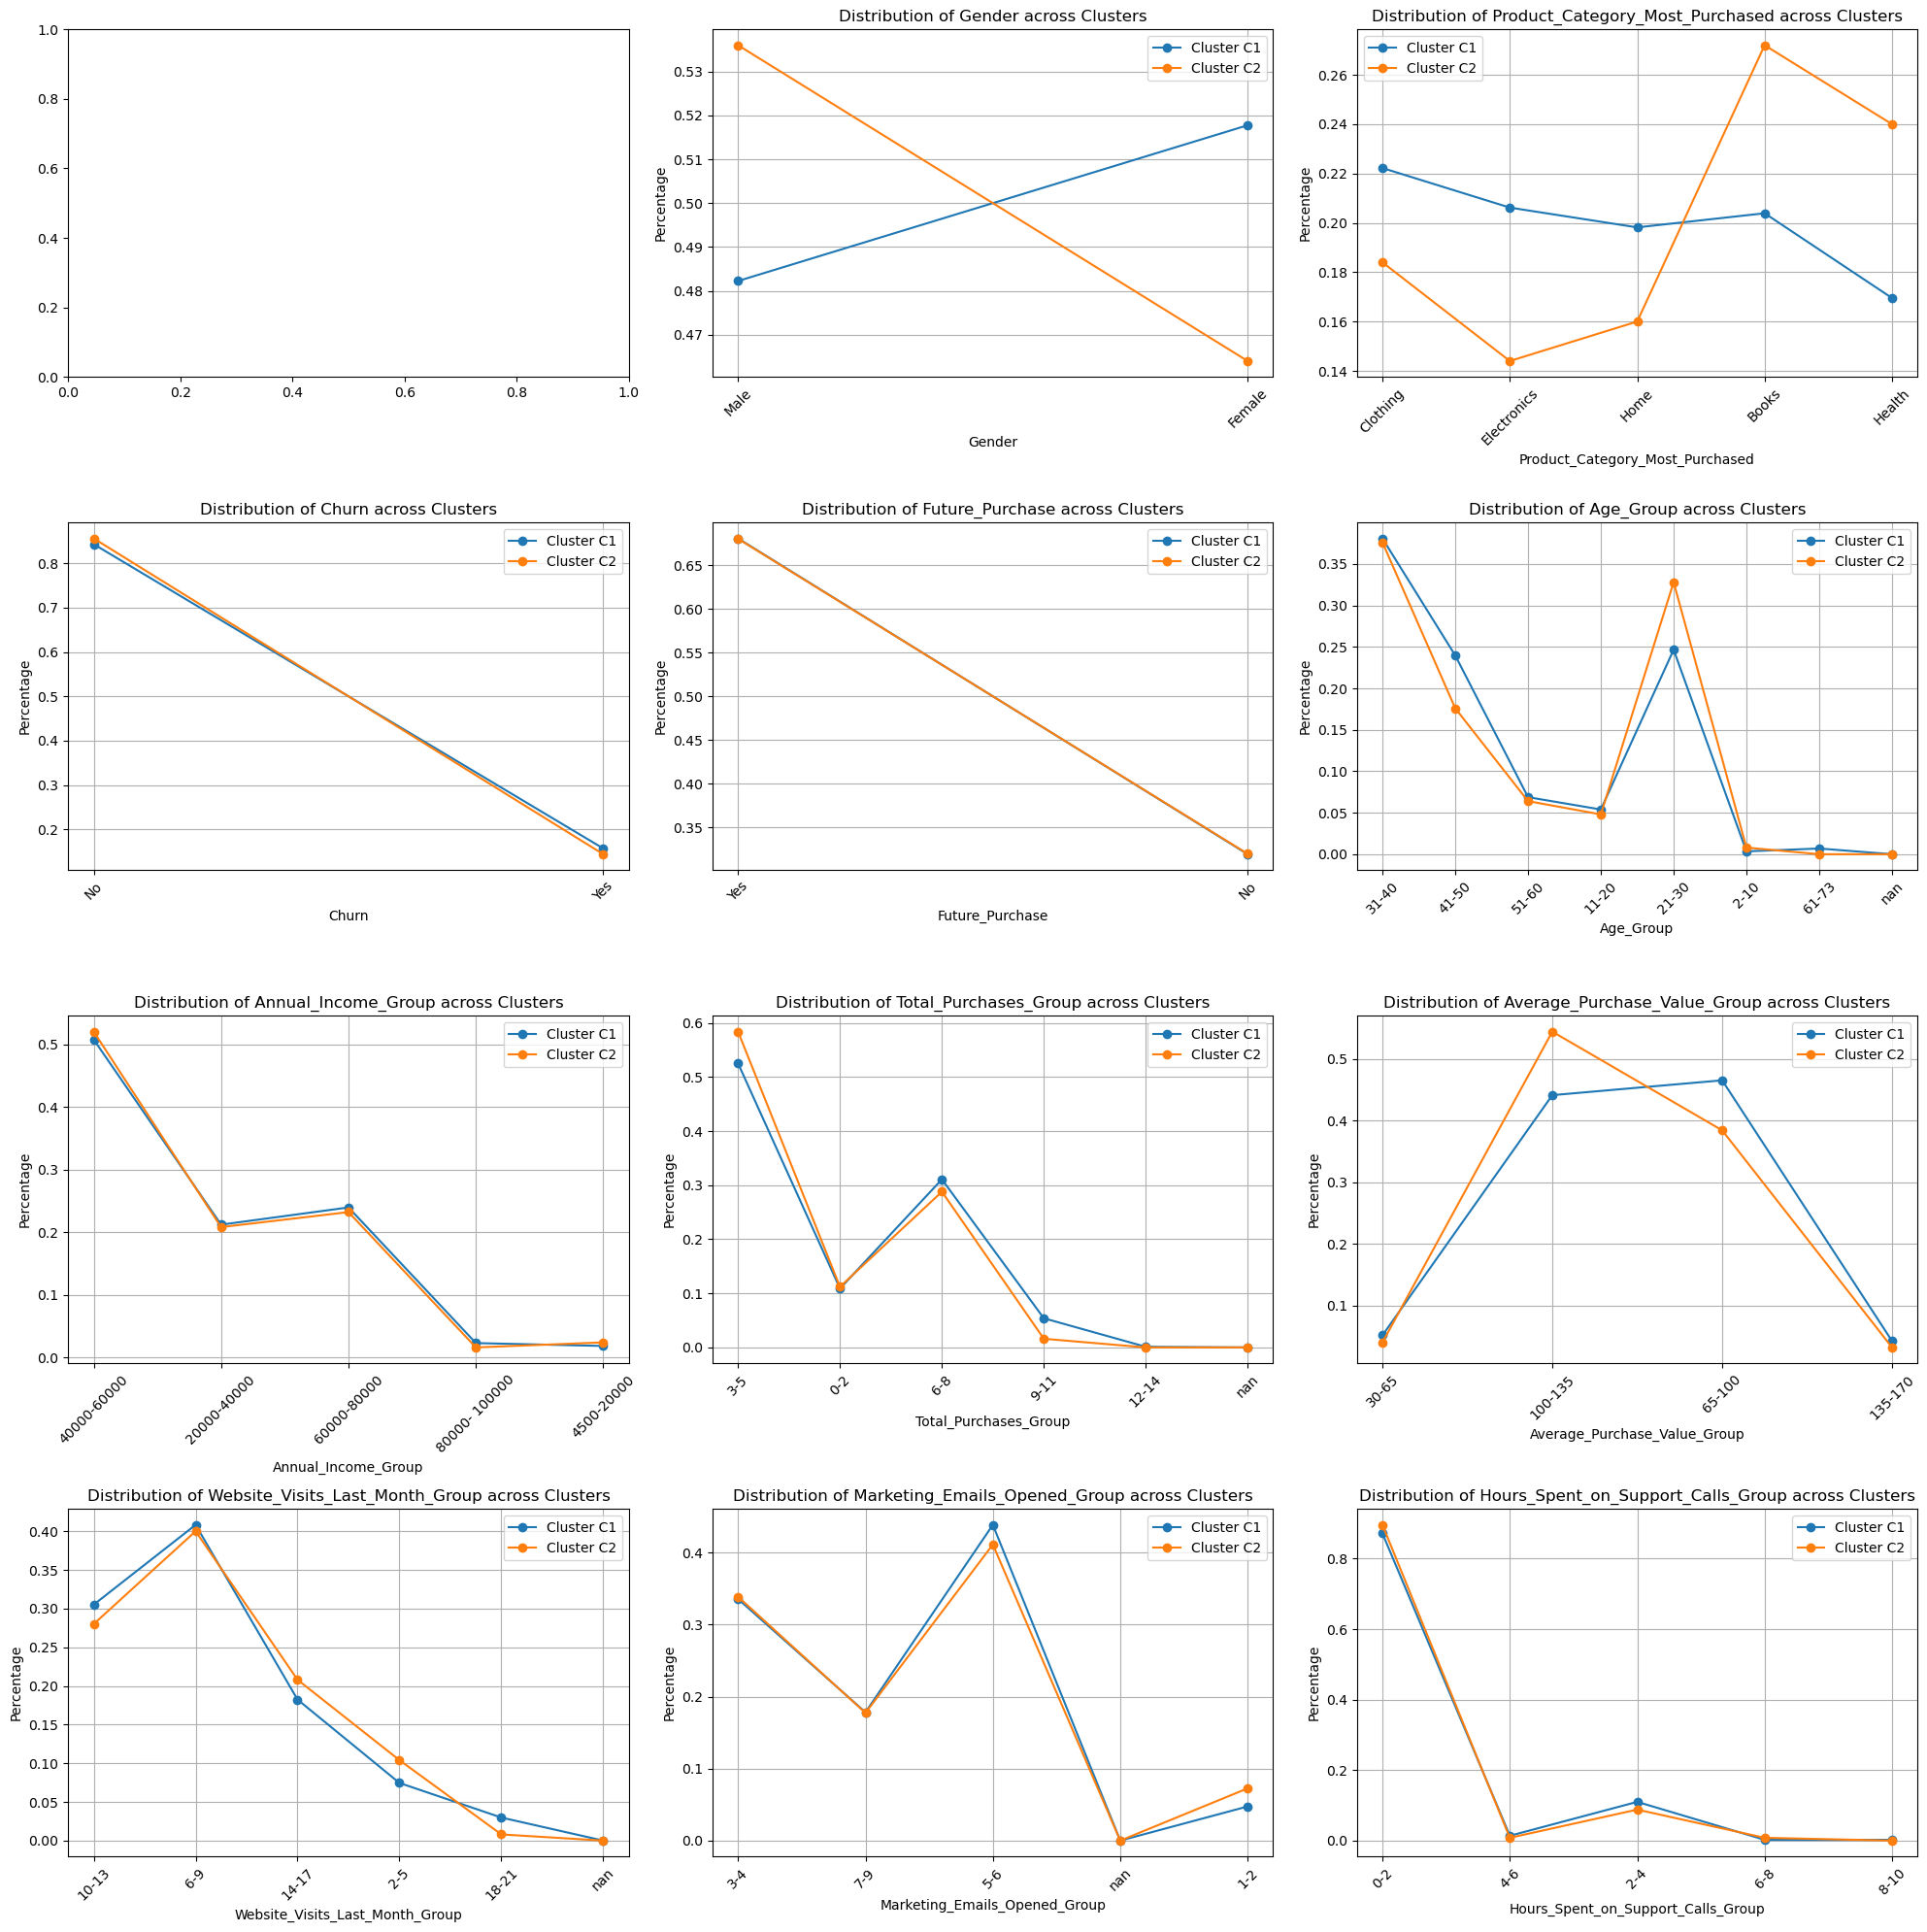

In [60]:
import matplotlib.pyplot as plt

# Define the grid for subplots
num_rows = 4
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# Flatten axes for easy iteration
axes = axes.flatten()

# Iterate over each categorical feature
for i, col in enumerate(data_label_categorical.columns):
    if col not in ['Hierachial Cluster Value', 'K-Means Cluster Value', 'Customer_ID']:
        if i < len(axes):  # Ensure the index doesn't exceed the number of axes
            ax = axes[i]

            # Iterate over each cluster label
            for cluster_label in cluster_labels:
                cluster_data = data_label_categorical[data_label_categorical['K-Means Cluster Value'] == cluster_label]

                # Calculate the frequency of each category for the current cluster and feature
                category_counts = cluster_data[col].value_counts(normalize=True)
                category_counts = category_counts.reindex(data_label_categorical[col].unique(), fill_value=0)  # Fill missing categories with 0

                # Plot bar chart for the distribution of categories in the current cluster
                ax.plot(category_counts.index.astype(str), category_counts.values, marker='o', label=f'Cluster {cluster_label}')  # Convert category labels to strings

            ax.set_title(f"Distribution of {col} across Clusters")
            ax.set_xlabel(col)
            ax.set_ylabel('Percentage')
            ax.set_xticklabels(category_counts.index.astype(str), rotation=45)  # Convert category labels to strings and rotate for better visibility
            ax.legend()
            ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

#### Hierachial Clustering

See code file and look under 'orange code for clustering.ows' to see how I came to my conclusion for the clustering patterns.

In [61]:
#Create a dataframe which includes the clustering
clustered_data_2 = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Advanced Data Science/Final Project/Data File/hierachial_clustering_normalised.csv')
cluster_2 = clustered_data_2['Cluster']
# Remove the first two values from the 'cluster' Series
cluster_trimmed_2 = clustered_data_2['Cluster'].iloc[2:]

# Reset the index of the 'cluster_trimmed' Series
cluster_trimmed_2_reset = cluster_trimmed_2.reset_index(drop=True)

In [62]:
# Add the trimmed 'cluster' Series as a new column 'Cluster Value' to the 'data' DataFrame
data['Hierachial Cluster Value'] = cluster_trimmed_2_reset

# Display the updated 'data' DataFrame
data.set_index('Customer_ID',inplace=True)
data.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Advanced Data Science/Final Project/Data File/data_with_cluster.csv')
data

,Age,Gender,Annual_Income,Total_Purchases,Average_Purchase_Value,Product_Category_Most_Purchased,Website_Visits_Last_Month,Marketing_Emails_Opened,Hours_Spent_on_Support_Calls,Churn,Future_Purchase,K-Means Cluster Value,Hierachial Cluster Value
Customer_ID,,,,,,,,,,,,,
1,39,Male,44520,4,44.291883,Clothing,12,3,0.360258,0,1,C1,C2
2,33,Female,52770,3,121.963922,Electronics,12,8,0.141300,1,1,C1,C2
3,41,Male,29793,5,100.599885,Electronics,9,4,0.482833,0,1,C1,C2
4,50,Female,35425,1,94.843412,Home,6,4,0.227715,0,1,C1,C2
5,32,Male,68006,6,119.680829,Books,6,3,1.032819,0,1,C1,C2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,32,Female,65528,5,91.889202,Books,15,7,0.195086,0,1,C1,C2
997,52,Male,22307,5,128.412366,Books,10,4,1.146425,0,1,C1,C2
998,41,Female,36057,7,97.511384,Home,6,6,0.756008,0,0,C1,C2


In [63]:
data_label_categorical['Hierachial Cluster Value'] = cluster_trimmed_2

In [64]:
#C1, C2, C3 data
C1_data = data_label_categorical[data_label_categorical['Hierachial Cluster Value'] == 'C1']
C2_data = data_label_categorical[data_label_categorical['Hierachial Cluster Value'] == 'C2']
C3_data = data_label_categorical[data_label_categorical['Hierachial Cluster Value'] == 'C3']

cluster_labels = ['C1', 'C2','C3']

/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_41533/4026523259.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(category_counts.index.astype(str), rotation=45)  # Convert category labels to strings and rotate for better visibility
/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_41533/4026523259.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(category_counts.index.astype(str), rotation=45)  # Convert category labels to strings and rotate for better visibility
/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_41533/4026523259.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(category_counts.index.astype(str), rotation=45)  # Convert category labels to strings and rotate for better visibility
/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_41533/4026523259.py:31: UserWarning: FixedForma

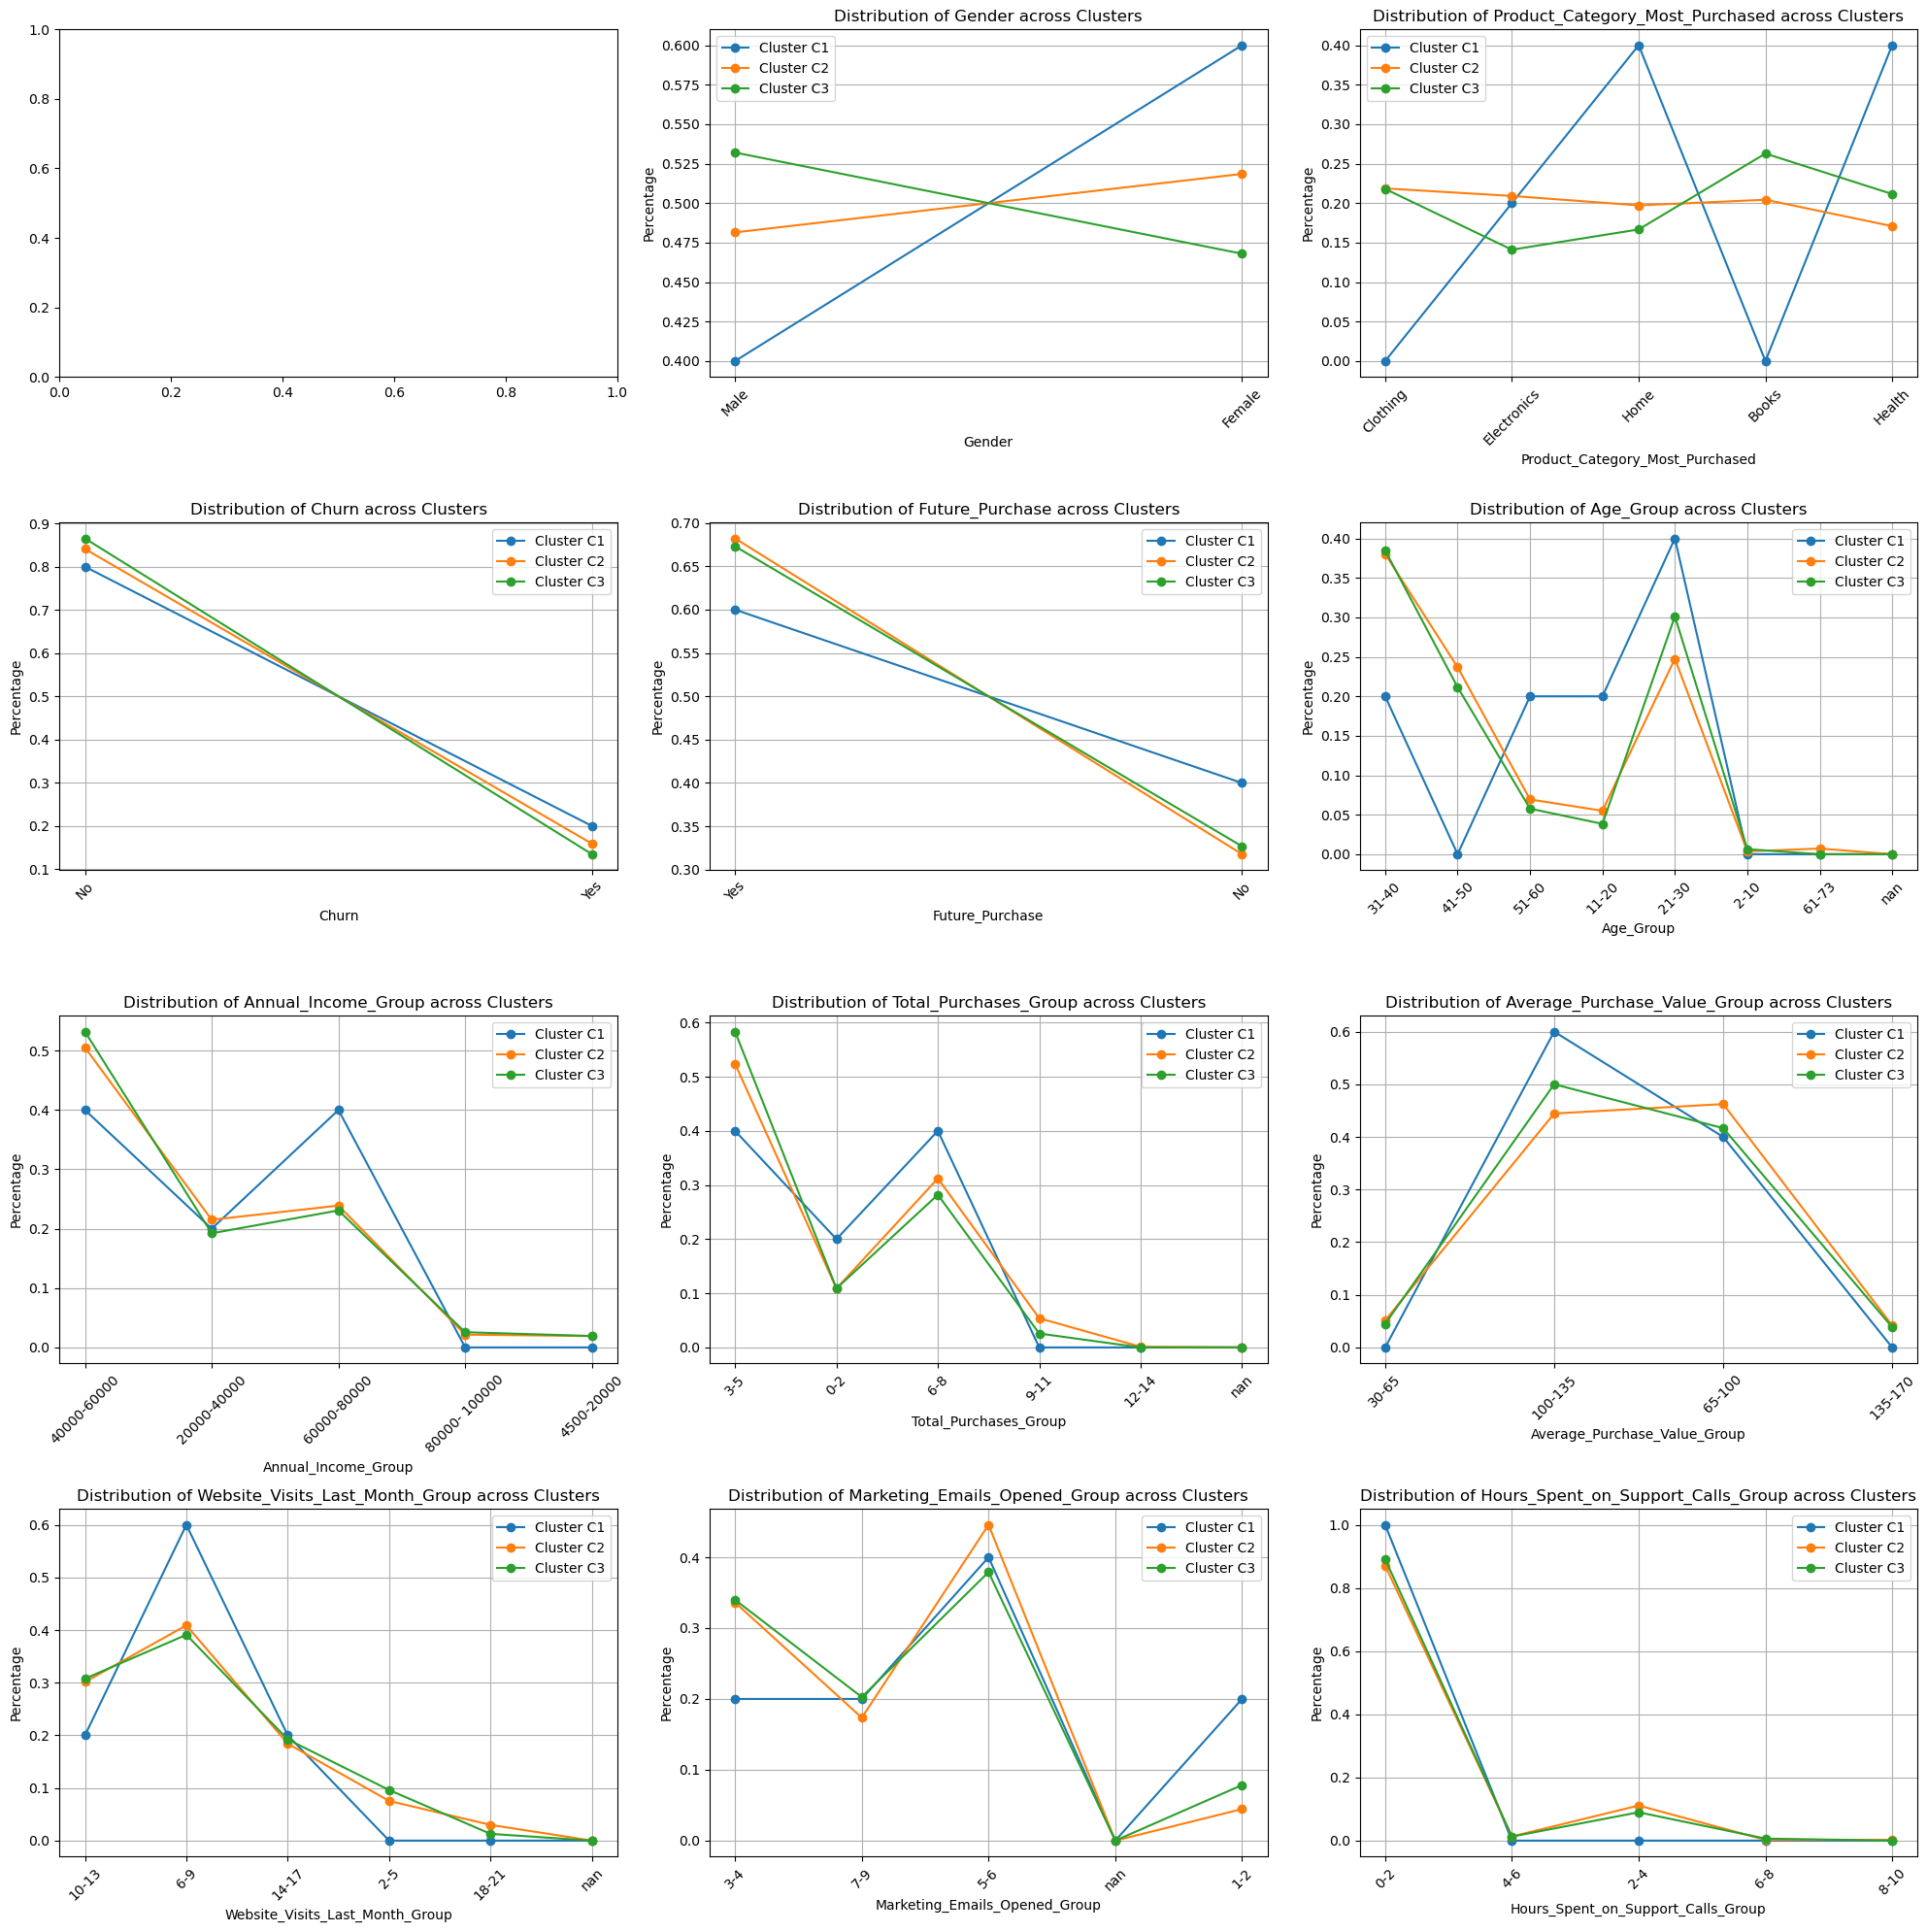

In [65]:
import matplotlib.pyplot as plt

# Define the grid for subplots
num_rows = 4
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# Flatten axes for easy iteration
axes = axes.flatten()

# Iterate over each categorical feature
for i, col in enumerate(data_label_categorical.columns):
    if col not in ['Hierachial Cluster Value', 'K-Means Cluster Value', 'Customer_ID']:
        if i < len(axes):  # Ensure the index doesn't exceed the number of axes
            ax = axes[i]

            # Iterate over each cluster label
            for cluster_label in cluster_labels:
                cluster_data = data_label_categorical[data_label_categorical['Hierachial Cluster Value'] == cluster_label]

                # Calculate the frequency of each category for the current cluster and feature
                category_counts = cluster_data[col].value_counts(normalize=True)
                category_counts = category_counts.reindex(data_label_categorical[col].unique(), fill_value=0)  # Fill missing categories with 0

                # Plot bar chart for the distribution of categories in the current cluster
                ax.plot(category_counts.index.astype(str), category_counts.values, marker='o', label=f'Cluster {cluster_label}')  # Convert category labels to strings

            ax.set_title(f"Distribution of {col} across Clusters")
            ax.set_xlabel(col)
            ax.set_ylabel('Percentage')
            ax.set_xticklabels(category_counts.index.astype(str), rotation=45)  # Convert category labels to strings and rotate for better visibility
            ax.legend()
            ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

### Compare K-Means Cluster Value and Hierachial Cluster Value

In [66]:
#Value counts of k-means cluster
values_k_means = data['K-Means Cluster Value'].value_counts()
values_k_means

C1    875
C2    125
Name: K-Means Cluster Value, dtype: int64

In [67]:
#Value counts of Hierachial Cluster
values_hierachial = data['Hierachial Cluster Value'].value_counts()
values_hierachial

C2    839
C3    156
C1      5
Name: Hierachial Cluster Value, dtype: int64

In [68]:
# Combine cluster assignments from K-means and hierarchical clustering
data['Combined Clusters'] = data['K-Means Cluster Value'].astype(str) + '_' + data['Hierachial Cluster Value'].astype(str)

# Compute overlap of clusters
overlap_counts = data['Combined Clusters'].value_counts()

overlap_counts

C1_C2    839
C2_C3    120
C1_C3     36
C2_C1      5
Name: Combined Clusters, dtype: int64

### Cluster Analysis

In [69]:
#Look at the dataframe data_label_categories
data_label_categorical['Cluster Value'] = data.reset_index()['Combined Clusters']
data_label_categorical

,Customer_ID,Gender,Product_Category_Most_Purchased,Churn,Future_Purchase,Age_Group,Annual_Income_Group,Total_Purchases_Group,Average_Purchase_Value_Group,Website_Visits_Last_Month_Group,Marketing_Emails_Opened_Group,Hours_Spent_on_Support_Calls_Group,K-Means Cluster Value,Hierachial Cluster Value,Cluster Value
0,1,Male,Clothing,No,Yes,31-40,40000-60000,3-5,30-65,10-13,3-4,0-2,NaN,NaN,C1_C2
1,2,Female,Electronics,Yes,Yes,31-40,40000-60000,3-5,100-135,10-13,7-9,0-2,NaN,NaN,C1_C2
2,3,Male,Electronics,No,Yes,41-50,20000-40000,3-5,100-135,6-9,3-4,0-2,C1,C2,C1_C2
3,4,Female,Home,No,Yes,51-60,20000-40000,0-2,65-100,6-9,3-4,0-2,C1,C2,C1_C2
4,5,Male,Books,No,Yes,31-40,60000-80000,6-8,100-135,6-9,3-4,0-2,C1,C2,C1_C2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,Female,Books,No,Yes,31-40,60000-80000,3-5,65-100,14-17,7-9,0-2,C1,C2,C1_C2
996,997,Male,Books,No,Yes,51-60,20000-40000,3-5,100-135,10-13,3-4,0-2,C2,C3,C1_C2
997,998,Female,Home,No,No,41-50,20000-40000,6-8,65-100,6-9,5-6,0-2,C1,C2,C1_C2
998,999,Male,Home,No,Yes,21-30,20000-40000,6-8,100-135,14-17,5-6,0-2,C1,C2,C1_C2


In [73]:
data_label_categorical['Cluster Value']

0      C1_C2
1      C1_C2
2      C1_C2
3      C1_C2
4      C1_C2
       ...  
995    C1_C2
996    C1_C2
997    C1_C2
998    C1_C2
999    C1_C2
Name: Cluster Value, Length: 1000, dtype: object

In [74]:
#C1, C2, C3 data
C1_data = data_label_categorical[data_label_categorical['Cluster Value'] == 'C1_C2']
C2_data = data_label_categorical[data_label_categorical['Cluster Value'] == 'C2_C3']
C3_data = data_label_categorical[data_label_categorical['Cluster Value'] == 'C1_C3']
C4_data = data_label_categorical[data_label_categorical['Cluster Value'] == 'C2_C1']

cluster_labels = ['C1_C2', 'C2_C3','C1_C3','C2_C1']

/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_41533/3324224042.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(category_counts.index.astype(str), rotation=45)  # Convert category labels to strings and rotate for better visibility
/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_41533/3324224042.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(category_counts.index.astype(str), rotation=45)  # Convert category labels to strings and rotate for better visibility
/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_41533/3324224042.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(category_counts.index.astype(str), rotation=45)  # Convert category labels to strings and rotate for better visibility
/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_41533/3324224042.py:31: UserWarning: FixedForma

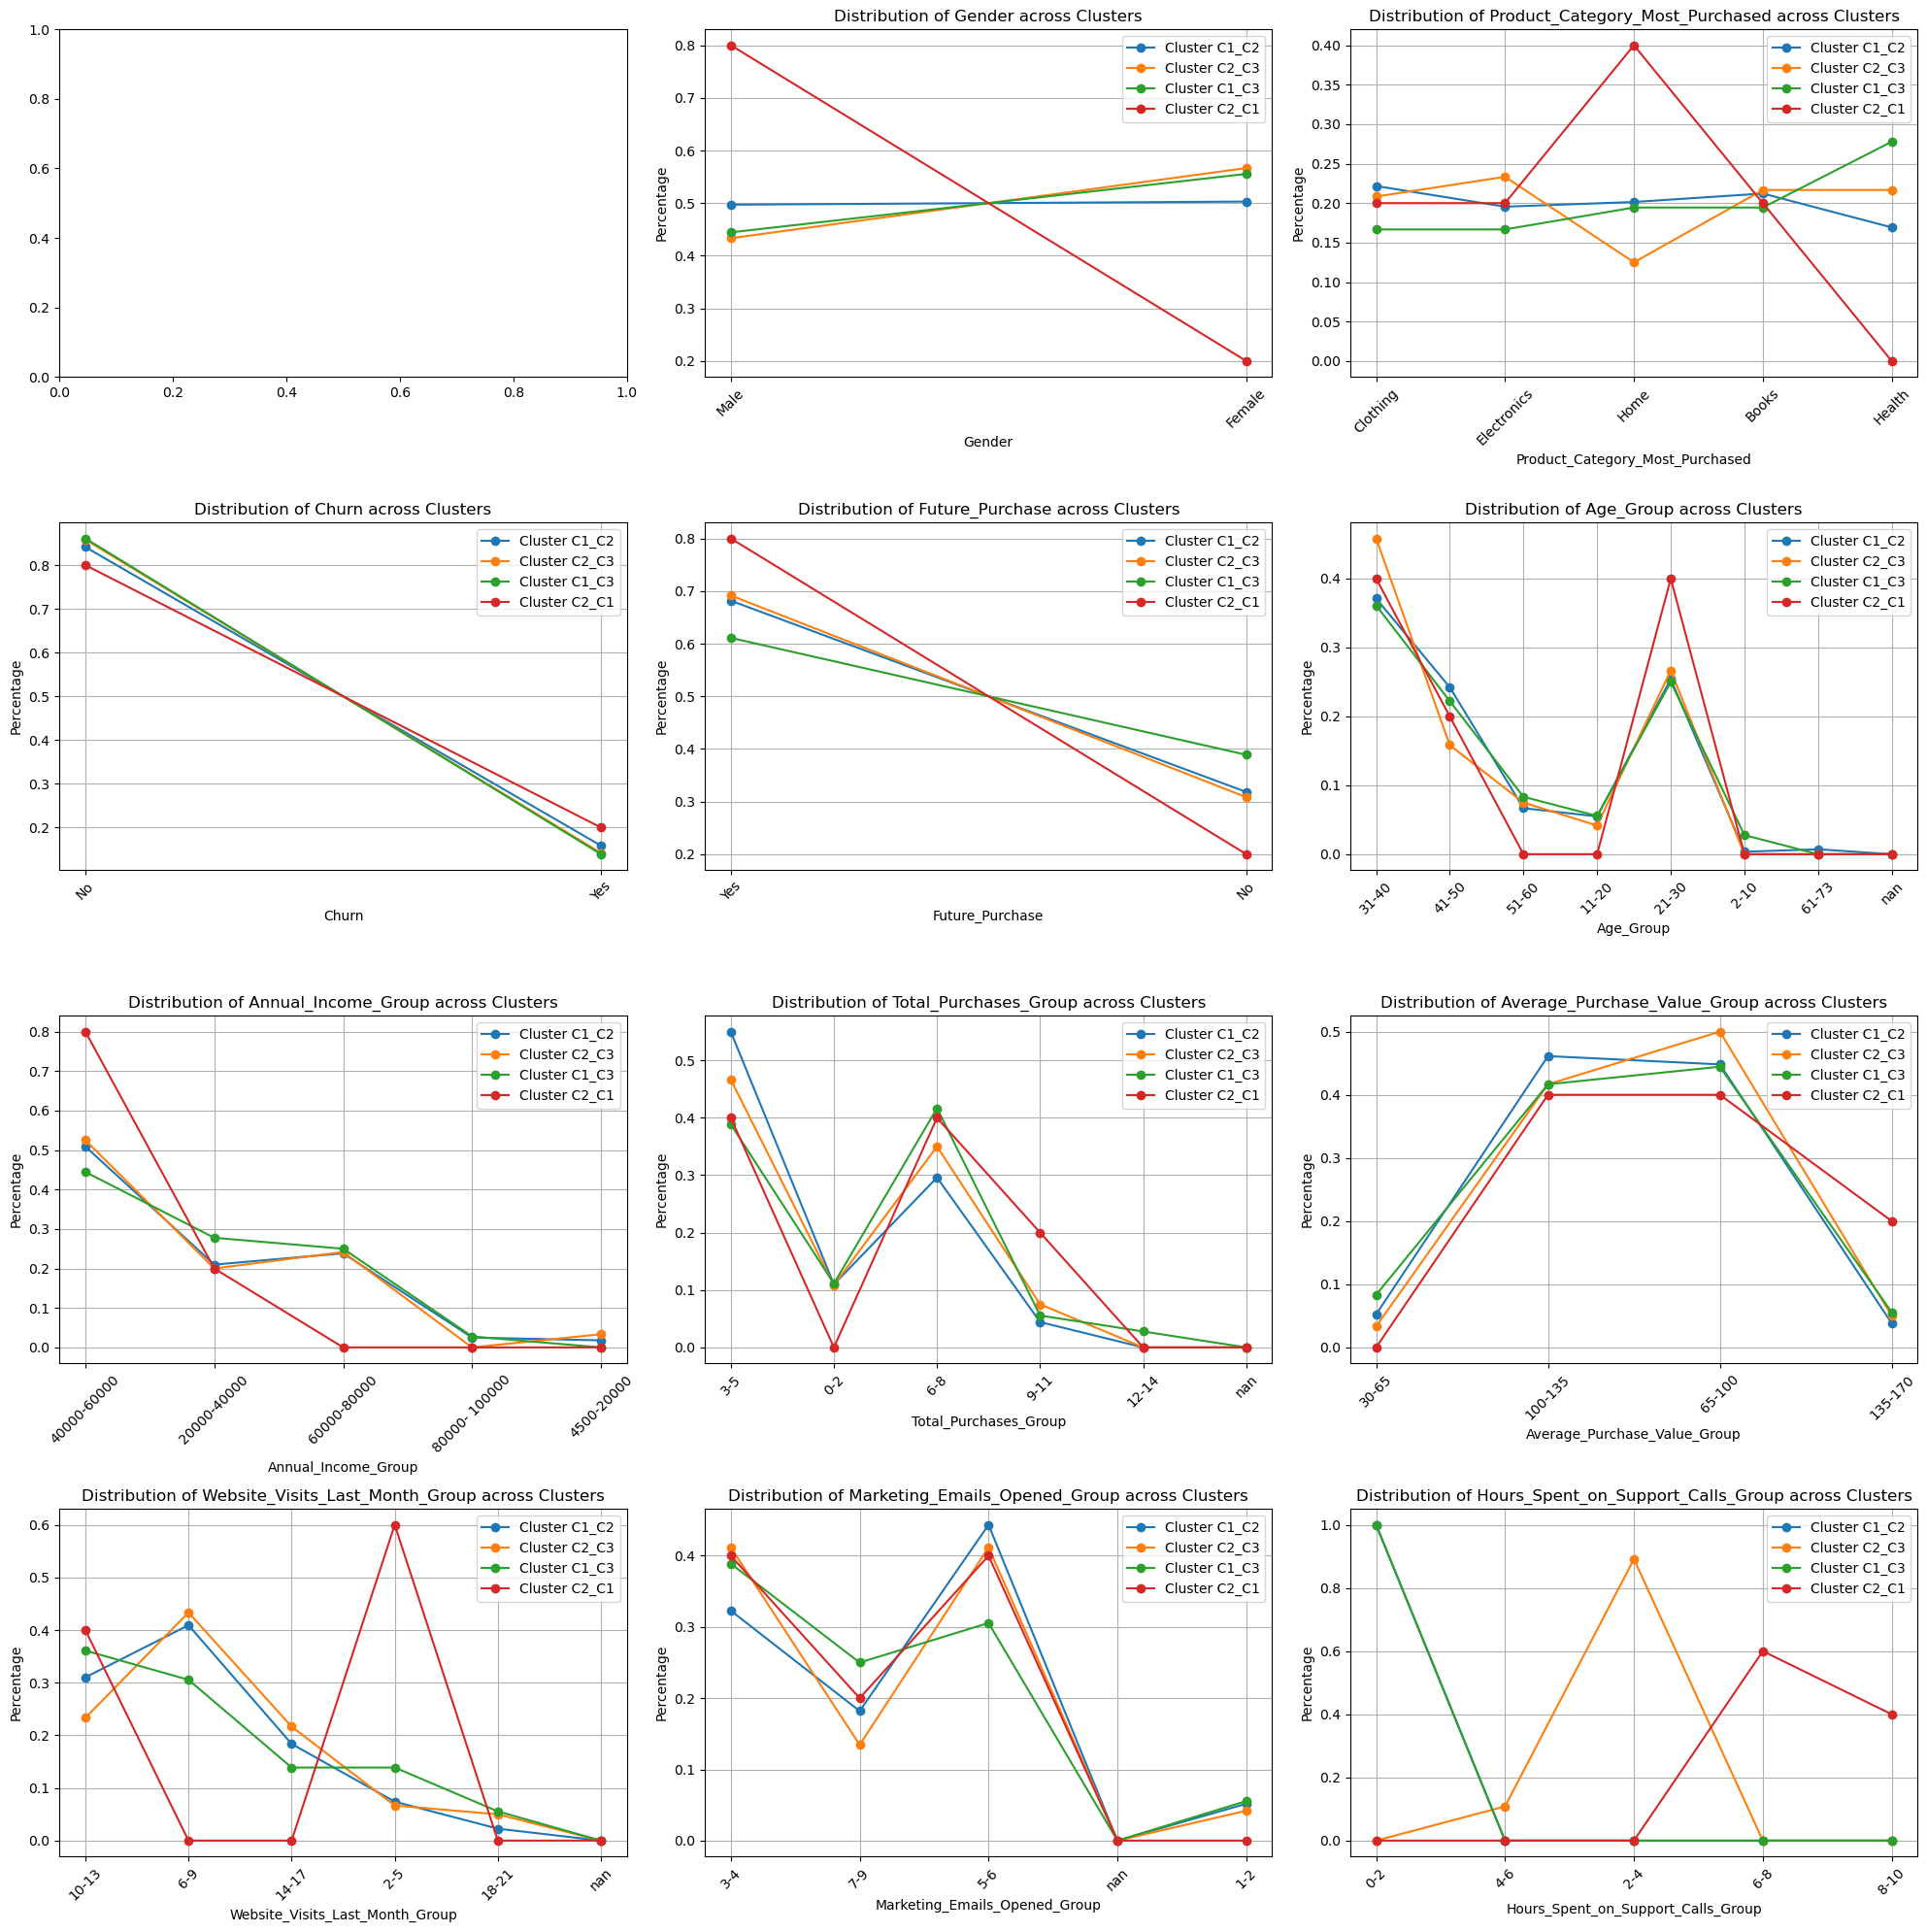

In [75]:
import matplotlib.pyplot as plt

# Define the grid for subplots
num_rows = 4
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# Flatten axes for easy iteration
axes = axes.flatten()

# Iterate over each categorical feature
for i, col in enumerate(data_label_categorical.columns):
    if col not in ['Hierachial Cluster Value', 'K-Means Cluster Value', 'Customer_ID']:
        if i < len(axes):  # Ensure the index doesn't exceed the number of axes
            ax = axes[i]

            # Iterate over each cluster label
            for cluster_label in cluster_labels:
                cluster_data = data_label_categorical[data_label_categorical['Cluster Value'] == cluster_label]

                # Calculate the frequency of each category for the current cluster and feature
                category_counts = cluster_data[col].value_counts(normalize=True)
                category_counts = category_counts.reindex(data_label_categorical[col].unique(), fill_value=0)  # Fill missing categories with 0

                # Plot bar chart for the distribution of categories in the current cluster
                ax.plot(category_counts.index.astype(str), category_counts.values, marker='o', label=f'Cluster {cluster_label}')  # Convert category labels to strings

            ax.set_title(f"Distribution of {col} across Clusters")
            ax.set_xlabel(col)
            ax.set_ylabel('Percentage')
            ax.set_xticklabels(category_counts.index.astype(str), rotation=45)  # Convert category labels to strings and rotate for better visibility
            ax.legend()
            ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

## 3. Logistic Regression
See orange

## 4. Neural Networks
See orange

In [72]:
#Normalised data, dummy variables
data_dummy_normalised.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Advanced Data Science/Final Project/Data File/Neural Network/normalised_dummy_neural_network_1.csv')
#integer encoding, dummy variables
data_dummy_integer_encoding.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Advanced Data Science/Final Project/Data File/Neural Network/integer_encoding_dummy_neural_network_2.csv')
#original data, dummy variables
data_dummy.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Advanced Data Science/Final Project/Data File/Neural Network/data_dummy_neural_network_3.csv')
#categorical label
data_label_categorical.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Advanced Data Science/Final Project/Data File/Neural Network/data_label_categorical_neural_network_4.csv')

## 5. PCA Analysis
See orange